#### Trial 1: PCA Analysis

This notebook has the objective of: 

1) Demostrar la variablidad de mis layers en mi time series. 
2) Demostrar como se calcula apropiadamente el PCA:

    2.a. Calcular las covarianzas de todas mis variables

    2.b. Calcular los eigenvalores y eigenvectores de la matriz de covarianza

    2.c. Ordenar los eigenvalores y eigenvectores de mayor a menor

    2.d. Seleccionar los k componentes principales (eigenvectores)
    
    2.e. Proyectar los datos originales sobre los componentes principales




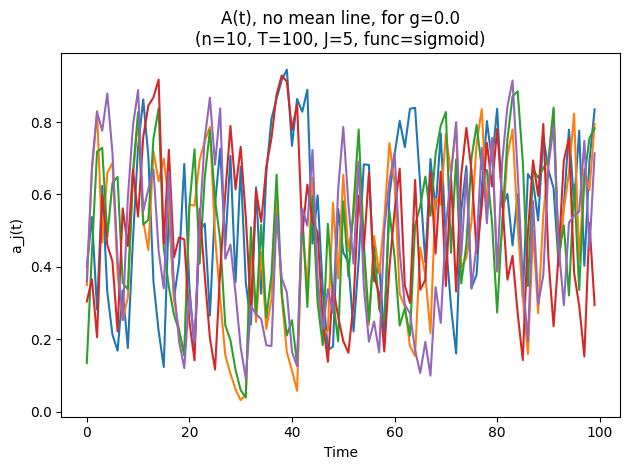

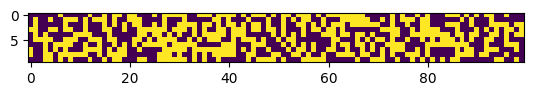

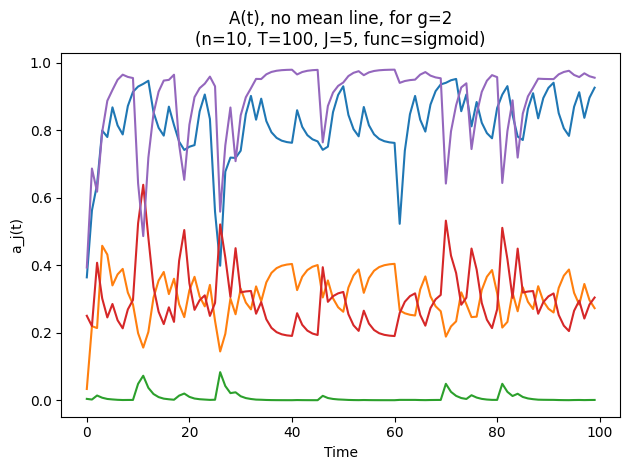

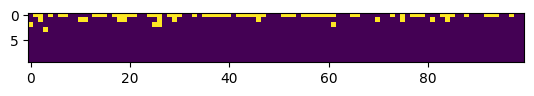

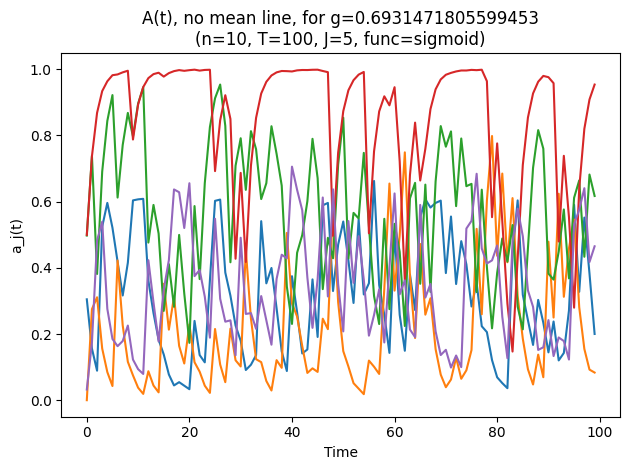

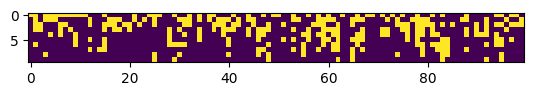

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
# --- MODEL HFM ---
def H_model_distribution(n, g):
    all_states = [np.array([int(x) for x in format(i, f'0{n}b')]) for i in range(2**n)]
    # in the state (0, 0, ..., 0) -> ms=0, in state (1, 0, ..., 0) -> ms=1, else =1 is the p(s=(0,0,0))=1
    energies = np.array([np.exp(-g * max(np.max(np.where(s == 1)[0] + 1) - 1, 0)) if np.any(s) else 1.0 for s in all_states])
    Z = np.sum(energies)
    probs = energies / Z
    return all_states, probs

import math

func= "sigmoid"
# Sample from the model
def sample_from_HFM(n, g, T):
    states, probs = H_model_distribution(n, g)
    indices = np.random.choice(len(states), size=T, p=probs)
    samples = np.array([states[i] for i in indices])
    # Transformar 0->-1 y 1->+1
    samples = 2 * samples - 1
    return samples

# Sigmoid Function.
def sigma(x):
    return 1 / (1 + np.exp(-x))

def activation(z, func=func):
    # Options: "step", "sigmoid", "tanh", "relu".
    if func == "step":  # Perceptron
        return np.where(z >= 0, 1.0, -1.0)
    elif func == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif func == "tanh":
        return np.tanh(z)
    elif func == "relu":
        return np.maximum(0.0, z)
    # Podrías agregar "leaky_relu", "elu", etc.
    else:
        raise ValueError("Func no reconocida")

""" 
    w = np.random.normal(loc=0.0, scale=1.0, size=n)
"""

def awareness_layers(S, J=20, eps=0):
    T, n = S.shape
    A = np.zeros((T, J))
    W = np.random.normal(0, 1, (J, n))  # cada layer tiene su propio w^j
    #W = np.ones((T, J))
    for j in range(J):
        # Inicializamos la "conciencia" de la réplica j
        a_j = 0.0
        for t in range(T):
            input_sum = np.dot(W[j], S[t])
            # Aplicamos la función de activación elegida
            out_val = activation(input_sum, func=func)
            # Actualizamos a_j con la dinámica de primer orden
            a_j = (1 - eps) * a_j + eps * out_val
            A[t, j] = a_j
    return A

if __name__ == "__main__":
    # Fixed parameters
    n = 10      # length of each state
    T = 100     # number of time steps
    J = 5      # number of layers
    eps = 0.5
    func = "sigmoid"

    # We'll explore 3 different values of g
    g_values = [0.0, 2, math.log(2.0)]

    # We'll store the mean time series for each g in a list
    mean_series_list = []

    for g in g_values:
        # 1) sample states S from HFM
        S = sample_from_HFM(n=n, g=g, T=T)
        # 2) compute awareness for J layers
        A = awareness_layers(S, J=J, eps=eps)

        # 3) Plot each layer's time series (WITHOUT the mean)
        plt.figure()
        for j in range(J):
            plt.plot(A[:, j], label=f"Layer {j}")

        plt.title(f"A(t), no mean line, for g={g}\n"
                  f"(n={n}, T={T}, J={J}, func={func})")
        plt.xlabel("Time")
        plt.ylabel("a_j(t)")
        plt.tight_layout()
        plt.show()
        plt.imshow(S.T)


Analysis for g = 0.000


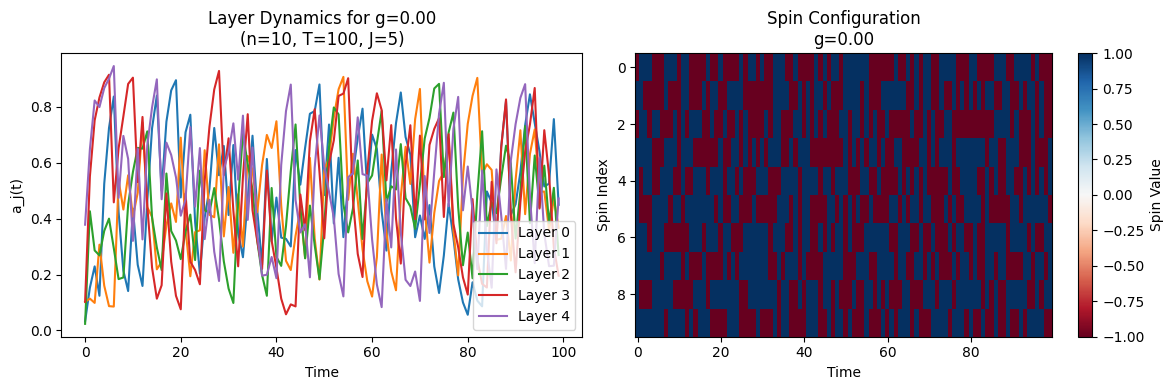


Step 1: Data Shape and Centering
Original data shape: (100, 5)
Number of variables (layers): 5
Number of samples (time points): 100

Step 2: Covariance Matrix
Covariance matrix shape: (5, 5)
Covariance matrix:
[[ 0.05049492 -0.00832608 -0.0008244   0.00585041 -0.0014372 ]
 [-0.00832608  0.04086108  0.00537504  0.0048785  -0.02325447]
 [-0.0008244   0.00537504  0.03429938  0.01268617 -0.0028568 ]
 [ 0.00585041  0.0048785   0.01268617  0.06384293 -0.01204091]
 [-0.0014372  -0.02325447 -0.0028568  -0.01204091  0.0505416 ]]

Step 3: Eigenvalues and Eigenvectors
Eigenvalues:
[0.08269151 0.06113652 0.04706982 0.02982786 0.0193142 ]

Number of eigenvalues: 5

Step 4: Explained Variance Ratio
Explained variance ratios:
[0.34449068 0.25469315 0.19609164 0.1242621  0.08046244]

Cumulative explained variance:
[0.34449068 0.59918383 0.79527546 0.91953756 1.        ]


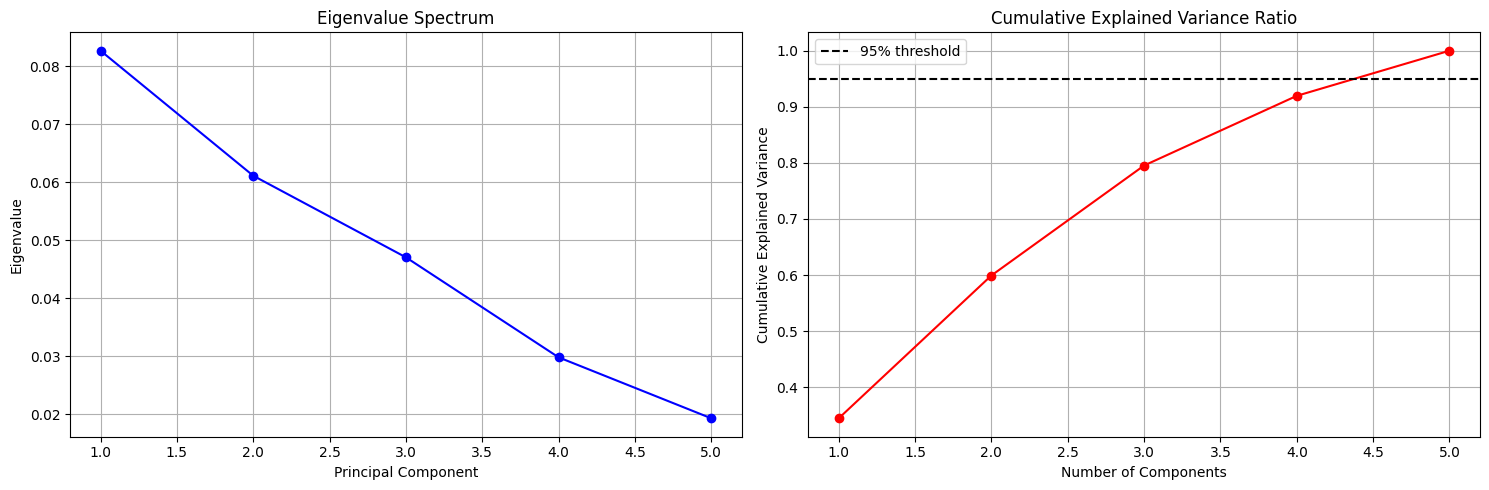


Analysis for g = 0.693


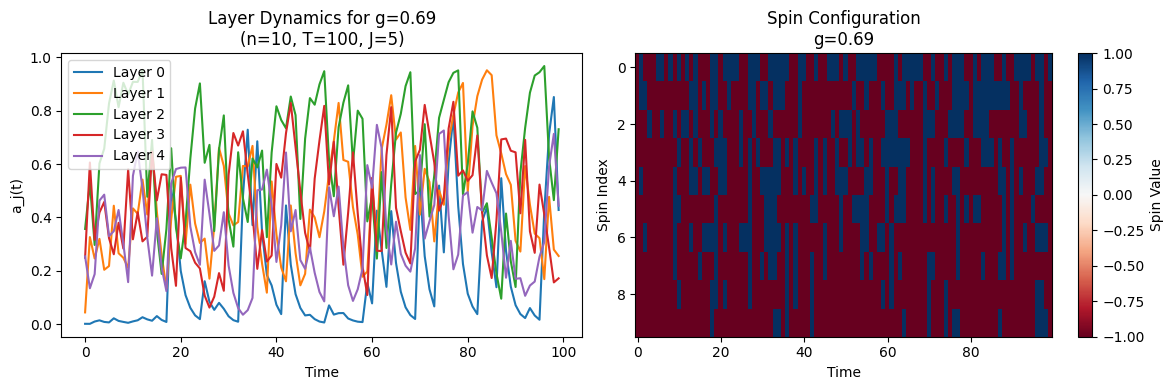


Step 1: Data Shape and Centering
Original data shape: (100, 5)
Number of variables (layers): 5
Number of samples (time points): 100

Step 2: Covariance Matrix
Covariance matrix shape: (5, 5)
Covariance matrix:
[[ 0.04379952  0.01165085 -0.00657903  0.00193889  0.01292085]
 [ 0.01165085  0.04446547 -0.00220833  0.0100841   0.00233623]
 [-0.00657903 -0.00220833  0.05237515 -0.00207855 -0.00556678]
 [ 0.00193889  0.0100841  -0.00207855  0.04015402 -0.01172017]
 [ 0.01292085  0.00233623 -0.00556678 -0.01172017  0.03171692]]

Step 3: Eigenvalues and Eigenvectors
Eigenvalues:
[0.06574165 0.05358468 0.04692995 0.02862478 0.01763   ]

Number of eigenvalues: 5

Step 4: Explained Variance Ratio
Explained variance ratios:
[0.30935637 0.25215008 0.22083531 0.13469784 0.0829604 ]

Cumulative explained variance:
[0.30935637 0.56150645 0.78234176 0.9170396  1.        ]


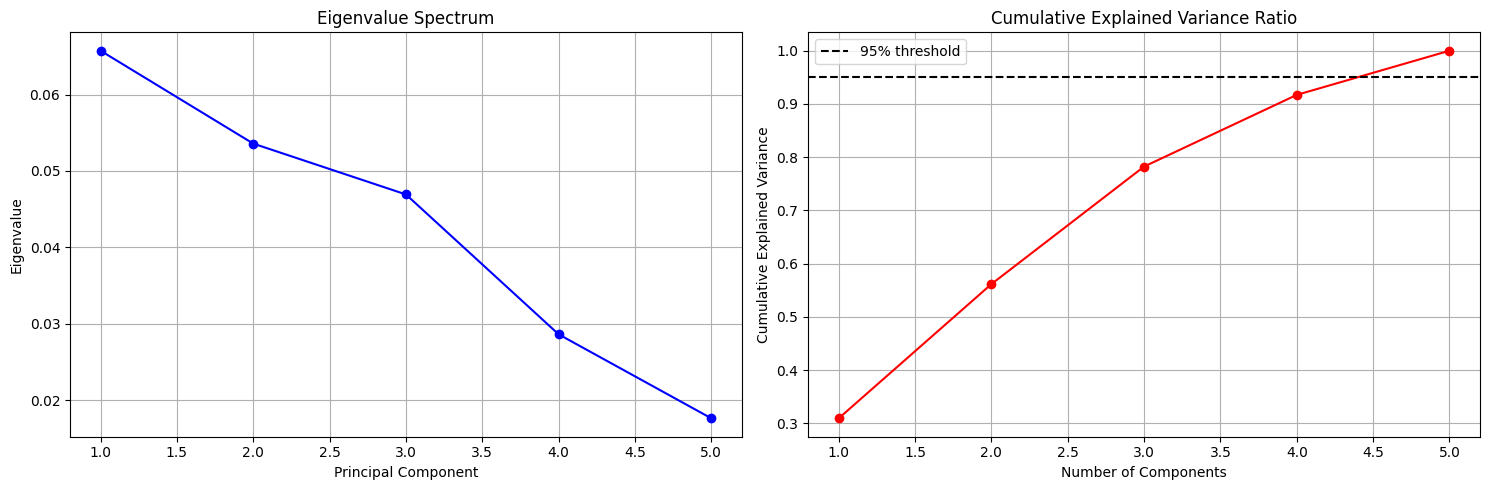


Analysis for g = 2.000


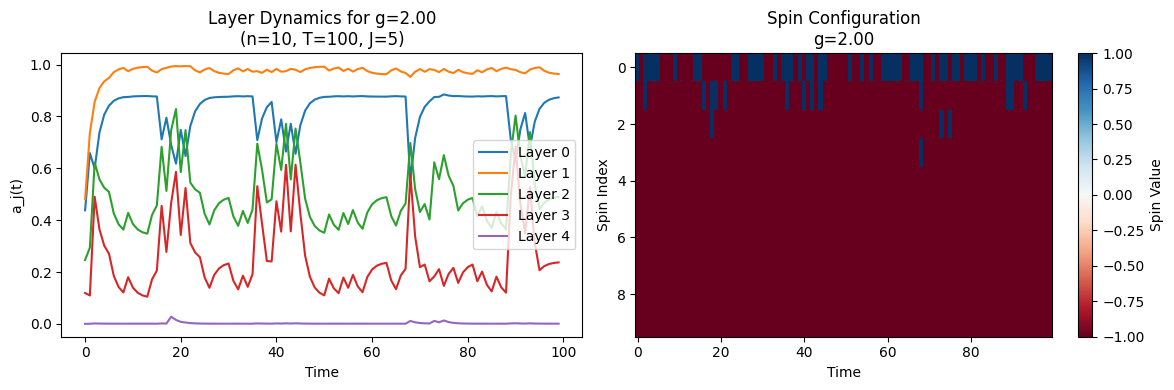


Step 1: Data Shape and Centering
Original data shape: (100, 5)
Number of variables (layers): 5
Number of samples (time points): 100

Step 2: Covariance Matrix
Covariance matrix shape: (5, 5)
Covariance matrix:
[[ 7.79613882e-03  2.59898246e-03 -6.22390974e-03 -9.00661895e-03
  -1.06622440e-04]
 [ 2.59898246e-03  3.27995123e-03  1.35615398e-03  4.74324421e-04
   2.08658971e-05]
 [-6.22390974e-03  1.35615398e-03  1.42448272e-02  1.50499002e-02
   2.34779805e-04]
 [-9.00661895e-03  4.74324421e-04  1.50499002e-02  1.84397305e-02
   1.76167422e-04]
 [-1.06622440e-04  2.08658971e-05  2.34779805e-04  1.76167422e-04
   1.34251468e-05]]

Step 3: Eigenvalues and Eigenvectors
Eigenvalues:
[3.57789183e-02 6.61624797e-03 9.80103488e-04 3.94371296e-04
 4.43186719e-06]

Number of eigenvalues: 5

Step 4: Explained Variance Ratio
Explained variance ratios:
[8.17354107e-01 1.51145359e-01 2.23900456e-02 9.00924383e-03
 1.01244113e-04]

Cumulative explained variance:
[0.81735411 0.96849947 0.99088951 0.9

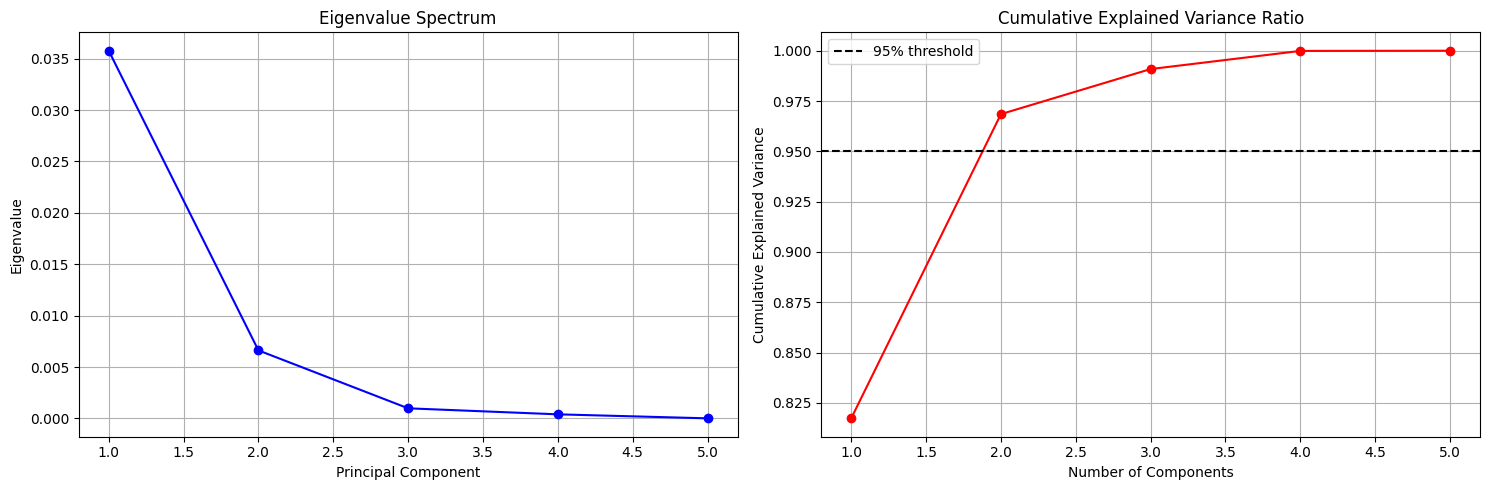

In [10]:
from typing import Tuple, List

def analyze_pca_step_by_step(A: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform step by step PCA analysis on layer activations.
    
    Args:
        A (np.ndarray): Layer activations matrix of shape (T, J)
            T: number of time points
            J: number of layers/variables
    
    Returns:
        Tuple containing:
        - Covariance matrix
        - Eigenvalues
        - Eigenvectors
        - Explained variance ratios
    """
    # 1. Center the data
    A_centered = A - np.mean(A, axis=0)
    print("\nStep 1: Data Shape and Centering")
    print(f"Original data shape: {A.shape}")
    print(f"Number of variables (layers): {A.shape[1]}")
    print(f"Number of samples (time points): {A.shape[0]}")
    
    # 2. Calculate covariance matrix
    cov_matrix = np.cov(A_centered.T)
    print("\nStep 2: Covariance Matrix")
    print(f"Covariance matrix shape: {cov_matrix.shape}")
    print("Covariance matrix:")
    print(cov_matrix)
    
    # 3. Calculate eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
    # Sort in descending order
    idx = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    
    print("\nStep 3: Eigenvalues and Eigenvectors")
    print("Eigenvalues:")
    print(eigenvals)
    print("\nNumber of eigenvalues:", len(eigenvals))
    
    # 4. Calculate explained variance ratio
    explained_variance_ratio = eigenvals / np.sum(eigenvals)
    print("\nStep 4: Explained Variance Ratio")
    print("Explained variance ratios:")
    print(explained_variance_ratio)
    print("\nCumulative explained variance:")
    print(np.cumsum(explained_variance_ratio))
    
    return cov_matrix, eigenvals, eigenvecs, explained_variance_ratio

def plot_pca_analysis(eigenvals: np.ndarray, explained_variance_ratio: np.ndarray) -> None:
    """
    Plot PCA analysis results.
    
    Args:
        eigenvals (np.ndarray): Array of eigenvalues
        explained_variance_ratio (np.ndarray): Array of explained variance ratios
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot eigenvalues
    ax1.plot(range(1, len(eigenvals) + 1), eigenvals, 'bo-')
    ax1.set_title('Eigenvalue Spectrum')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Eigenvalue')
    ax1.grid(True)
    
    # Plot cumulative explained variance
    cumsum = np.cumsum(explained_variance_ratio)
    ax2.plot(range(1, len(cumsum) + 1), cumsum, 'ro-')
    ax2.axhline(y=0.95, color='k', linestyle='--', label='95% threshold')
    ax2.set_title('Cumulative Explained Variance Ratio')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_layer_dynamics_with_pca(n: int = 10, T: int = 100, J: int = 5, eps: float = 0.5, 
                                func: str = "sigmoid", g_values: list = None) -> None:
    """
    Plot layer dynamics and perform PCA analysis for different coupling parameters.
    
    Args:
        n (int): Number of spins
        T (int): Number of time steps
        J (int): Number of layers
        eps (float): Learning rate
        func (str): Activation function type
        g_values (list): List of coupling parameters to explore
    """
    if g_values is None:
        g_values = [0.0, math.log(2.0), 2.0]
    
    for g in g_values:
        print(f"\n{'='*50}")
        print(f"Analysis for g = {g:.3f}")
        print('='*50)
        
        # 1. Sample states from HFM
        S = sample_from_HFM(n=n, g=g, T=T)
        
        # 2. Compute awareness for J layers
        A = awareness_layers(S, J=J, eps=eps)
        
        # 3. Plot layer dynamics
        plt.figure(figsize=(12, 4))
        
        # Layer dynamics subplot
        plt.subplot(121)
        for j in range(J):
            plt.plot(A[:, j], label=f"Layer {j}")
        plt.title(f"Layer Dynamics for g={g:.2f}\n(n={n}, T={T}, J={J})")
        plt.xlabel("Time")
        plt.ylabel("a_j(t)")
        plt.legend()
        
        # Spin configuration subplot
        plt.subplot(122)
        plt.imshow(S.T, aspect='auto', cmap='RdBu')
        plt.title(f"Spin Configuration\ng={g:.2f}")
        plt.xlabel("Time")
        plt.ylabel("Spin Index")
        plt.colorbar(label='Spin Value')
        
        plt.tight_layout()
        plt.show()
        
        # 4. Perform PCA analysis
        cov_matrix, eigenvals, eigenvecs, explained_variance = analyze_pca_step_by_step(A)
        
        # 5. Plot PCA results
        plot_pca_analysis(eigenvals, explained_variance)

if __name__ == "__main__":
    # Example usage with PCA analysis
    np.random.seed(42)  # For reproducibility
    plot_layer_dynamics_with_pca(
        n=10,      # Number of spins
        T=100,     # Time steps
        J=5,       # Number of layers
        eps=0.5,   # Learning rate
        func="sigmoid",
        g_values=[0.0, math.log(2.0), 2.0]  # Different coupling regimes
    ) 
